# Práctica 2 - Clasificación supervisada en scikit-learn

**Nombres:** 
 - **Alejandro Moya Moya** - LinkedIn: https://www.linkedin.com/in/alejandro-moya-moya/
 - **Jorge Valero Molina** - LinkedIn: https://www.linkedin.com/in/jorge-valero-molina-0a2a0512b/
 
**Año:** 2017/18

**Revisión:** 1.2

# Indice:
* [1. Antes de empezar...](#1.-Antes-de-empezar...)
* [2. Carga de los Datasets](#2.-Carga-de-los-Datasets)
* [3. Algoritmo GridSearch](#3.-Algoritmo-GridSearch)
    * [3.1. KNN](#3.1.-KNN)
        * [3.1.1 Pima](#3.1.1-Pima)
        * [3.1.2 Wisconsin](#3.1.2-Wisconsin)
    * [3.2. Árbol de decisión](#3.2.-Árbol-de-decisión)
        * [3.2.1 Pima](#3.2.1-Pima)
        * [3.2.2 Wisconsin](#3.2.2-Wisconsin)
* [4. Comparación de algoritmos - KNN vs DecisionTree](#4.-Comparación-de-algoritmos---KNN-vs-DecisionTree)
* [5. Estudio de los algoritmos](#5.-Estudio-de-los-algoritmos)
    * [5.1. KNN - Problemas con el calculo de fronteras - No realizado](#5.1.-KNN---Problemas-con-el-calculo-de-fronteras---No-realizado)
        * [5.1.1 Pima](#5.1.1-Pima)
        * [5.1.2 Wisconsin](#5.1.2-Wisconsin)
    * [5.2. Árboles de Decisión](#5.2.-Árboles-de-Decisión)
        * [5.2.1 Pima](#5.2.1-Pima)
        * [5.2.2 Wisconsin](#5.2.2-Wisconsin)
* [6. Algoritmo GridSearch - Manual](#6.-Algoritmo-GridSearch---Manual)
* [7. Estudio de un kernel de kaggle](#7.-Estudio-de-un-kernel-de-kaggle)
_________________________________________________

## 1. Antes de empezar...

In [1]:
# Cargamos las librerias necesarias para poder realizar la práctica.

import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import neighbors
import sklearn.metrics as metrics
from sklearn import tree
import pydotplus 
from IPython.display import Image  
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import seaborn as sns
sns.set(color_codes=True)

# Este codigo configura matplotlib para una representacion adecuada
%matplotlib inline
mpl.rcParams["figure.figsize"] = "8, 4"
import warnings
warnings.simplefilter("ignore")

# Establecemos una semilla para poder obtener siempre los resultados
import random
seed=1234
np.random.seed(seed)




######## Imputer del Train y el Test ########

def ImputerTrainTest(estrategia, train_atts, test_atts):
    imp = Imputer(strategy=estrategia)
    imp = imp.fit(train_atts)
    X = imp.transform(train_atts)
    train_attsCopy = pd.DataFrame(X, columns = train_atts.columns)

    imp = imp.fit(test_atts)
    X = imp.transform(test_atts)
    test_attsCopy = pd.DataFrame(X, columns = test_atts.columns)
    return (train_attsCopy, test_attsCopy)




######## Funciones de las gráficas ########

def classifierPrintBoundaries(model, train_atts, train_label, test_atts, test_label):

    attsPair = [ (x,y) for x in train_atts.columns for y in train_atts.columns if x != y]
    
    for (att1_name, att2_name) in attsPair:
        
        xx, yy = np.meshgrid(np.arange(min(train_atts[att1_name])-1, max(train_atts[att1_name])+1, 0.05),
                             np.arange(min(train_atts[att2_name])-1, max(train_atts[att2_name])+1, 0.05))

        mesh = pd.DataFrame({ 'x' : xx.ravel(), 'y' : yy.ravel() })
        
        cls = model.fit(train_atts[[att1_name, att2_name]], train_label)

        Z = cls.predict(mesh)
        mesh = mesh.assign( label = pd.Categorical(Z, categories=train_label.cat.categories) )

        colors = ["#4D73AB","#54A86F","#C44D54"]

        mesh = mesh.assign(colors = mesh.label.cat.codes.map(lambda x: colors[x]))
        colorBoundary = list(mesh.label.cat.codes.map(lambda x: colors[x]))
        colorObservations = list(test_label.cat.codes.map(lambda x: colors[x]))

        fig, ax = plt.subplots()
        # Plot using Seaborn
        sns.regplot(x='x', y='y', data=mesh,
                   fit_reg=False, 
                   scatter_kws={'color': colorBoundary})

        sns.regplot(x=att1_name, y=att2_name, data=test_atts,
                   fit_reg=False,
                   scatter_kws={'color': colorObservations,  'lw': 1, 'edgecolor':'#FFFFFF'})

def imprimeArbol(model, data, width):
    fnames = data.columns.values[:-1]
    lnames = data['label'].unique()
    dot_data = tree.export_graphviz(model, out_file=None, 
                             feature_names=fnames,  
                             class_names=lnames,  
                             filled=True, rounded=True,  
                             special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    return Image(graph.create_png(), width=width) 
        


# 2. Carga de los Datasets
Cargamos un Dataset, para esta práctica usaremos 'Pima' y 'Wisconsin'

In [2]:
# Cargamos el fichero con el conjunto de datos. OJO: colocar el fichero de datos en el mismo directorio que esta libreta
df = {}
dfAttributes = {}
dfLabel = {}
df[1] = pd.read_csv("pima.csv", dtype={ "label": 'category'})

# Preprocesamiento de pima manual (Cambiar los 0's por Nan's)
df[1]["plas"].replace(0, np.nan, inplace=True)
df[1]["pres"].replace(0, np.nan, inplace=True)
df[1]["skin"].replace(0, np.nan, inplace=True)
df[1]["insu"].replace(0, np.nan, inplace=True)
df[1]["mass"].replace(0, np.nan, inplace=True)

dfAttributes[1] = df[1].drop('label', 1)
dfLabel[1] = df[1]['label']

df[2] = pd.read_csv("wisconsin.csv", dtype={ "label": 'category'})
df[2].drop('patientId', 1, inplace=True)
dfAttributes[2] = df[2].drop('label', 1)
dfLabel[2] = df[2]['label']

In [3]:
# Dividimos cada Dataset en train/test para realizar los experimentos.
# Para ello realizados un Holdout estratificado.
from sklearn.model_selection import train_test_split
train_atts = {}
test_atts = {}
train_label = {}
test_label = {}
# df[1]
train_atts[1], test_atts[1], train_label[1], test_label[1] = train_test_split( 
    dfAttributes[1],
    dfLabel[1],
    test_size=0.2,
    random_state=seed,
    stratify=dfLabel[1])

# df[2]
train_atts[2], test_atts[2], train_label[2], test_label[2] = train_test_split( 
    dfAttributes[2],
    dfLabel[2],
    test_size=0.2,
    random_state=seed,
    stratify=dfLabel[2])

# 3. Algoritmo GridSearch


## 3.1. KNN

#### 3.1.1 Pima

In [4]:
estimator = Pipeline([("imputer", Imputer()),
                      ("KNN", neighbors.KNeighborsClassifier())])

param_grid = { 'imputer__strategy': ['mean','most_frequent', 'median'],'KNN__n_neighbors' : np.arange(1,100)}
                         

clf = GridSearchCV(
    estimator,
    param_grid,
    scoring = 'accuracy',
    cv = 10
)

In [5]:
# Entrenamos el modelo obtenido del GridSearchCV
fitted = clf.fit(train_atts[1], train_label[1])

In [6]:
fitted.best_params_

{'KNN__n_neighbors': 61, 'imputer__strategy': 'mean'}

In [7]:
fitted.best_score_

0.77687296416938112

In [8]:
means = fitted.cv_results_['mean_test_score']
stds = fitted.cv_results_['std_test_score']
conf = fitted.cv_results_['params']

#Nos mostrará el error calculado para los diferentes parametros definidos en param_grid
for mean, std, params in zip(means, stds, conf):
    print("%0.3f (+/-%0.03f) for %r"
         % (mean, std*2, params))

0.723 (+/-0.105) for {'KNN__n_neighbors': 1, 'imputer__strategy': 'mean'}
0.713 (+/-0.115) for {'KNN__n_neighbors': 1, 'imputer__strategy': 'most_frequent'}
0.721 (+/-0.102) for {'KNN__n_neighbors': 1, 'imputer__strategy': 'median'}
0.728 (+/-0.097) for {'KNN__n_neighbors': 2, 'imputer__strategy': 'mean'}
0.721 (+/-0.090) for {'KNN__n_neighbors': 2, 'imputer__strategy': 'most_frequent'}
0.735 (+/-0.075) for {'KNN__n_neighbors': 2, 'imputer__strategy': 'median'}
0.712 (+/-0.133) for {'KNN__n_neighbors': 3, 'imputer__strategy': 'mean'}
0.718 (+/-0.117) for {'KNN__n_neighbors': 3, 'imputer__strategy': 'most_frequent'}
0.725 (+/-0.120) for {'KNN__n_neighbors': 3, 'imputer__strategy': 'median'}
0.726 (+/-0.103) for {'KNN__n_neighbors': 4, 'imputer__strategy': 'mean'}
0.721 (+/-0.120) for {'KNN__n_neighbors': 4, 'imputer__strategy': 'most_frequent'}
0.739 (+/-0.098) for {'KNN__n_neighbors': 4, 'imputer__strategy': 'median'}
0.720 (+/-0.102) for {'KNN__n_neighbors': 5, 'imputer__strategy': 'm

In [9]:
# Predecimos con el modelo entrenado el conjunto de test
prediction = clf.predict(test_atts[1])
%timeit -n 50 clf.predict(test_atts[1])

3.36 ms ± 393 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [10]:
metrics.confusion_matrix(test_label[1], prediction)

array([[78, 22],
       [26, 28]])

In [11]:
metrics.accuracy_score(test_label[1], prediction)

0.68831168831168832

In [12]:
metrics.recall_score(test_label[1], prediction, pos_label="tested_positive")

0.51851851851851849

#### 3.1.2 Wisconsin

In [13]:
estimator = Pipeline([("imputer", Imputer()),
                      ("KNN", neighbors.KNeighborsClassifier())])

param_grid = { 'imputer__strategy': ['mean','most_frequent', 'median'],'KNN__n_neighbors' : np.arange(1,100)}
                         

clf = GridSearchCV(
    estimator,
    param_grid,
    scoring = 'accuracy',
    cv = 10
)


In [14]:
fitted = clf.fit(train_atts[2], train_label[2])

In [15]:
fitted.best_params_

{'KNN__n_neighbors': 5, 'imputer__strategy': 'most_frequent'}

In [16]:
fitted.best_score_

0.97495527728085862

In [17]:
means = fitted.cv_results_['mean_test_score']
stds = fitted.cv_results_['std_test_score']
conf = fitted.cv_results_['params']

for mean, std, params in zip(means, stds, conf):
    print("%0.3f (+/-%0.03f) for %r"
         % (mean, std*2, params))

0.964 (+/-0.057) for {'KNN__n_neighbors': 1, 'imputer__strategy': 'mean'}
0.970 (+/-0.050) for {'KNN__n_neighbors': 1, 'imputer__strategy': 'most_frequent'}
0.970 (+/-0.050) for {'KNN__n_neighbors': 1, 'imputer__strategy': 'median'}
0.955 (+/-0.032) for {'KNN__n_neighbors': 2, 'imputer__strategy': 'mean'}
0.952 (+/-0.038) for {'KNN__n_neighbors': 2, 'imputer__strategy': 'most_frequent'}
0.952 (+/-0.038) for {'KNN__n_neighbors': 2, 'imputer__strategy': 'median'}
0.973 (+/-0.042) for {'KNN__n_neighbors': 3, 'imputer__strategy': 'mean'}
0.973 (+/-0.033) for {'KNN__n_neighbors': 3, 'imputer__strategy': 'most_frequent'}
0.973 (+/-0.033) for {'KNN__n_neighbors': 3, 'imputer__strategy': 'median'}
0.966 (+/-0.037) for {'KNN__n_neighbors': 4, 'imputer__strategy': 'mean'}
0.970 (+/-0.032) for {'KNN__n_neighbors': 4, 'imputer__strategy': 'most_frequent'}
0.970 (+/-0.032) for {'KNN__n_neighbors': 4, 'imputer__strategy': 'median'}
0.971 (+/-0.048) for {'KNN__n_neighbors': 5, 'imputer__strategy': 'm

In [18]:
prediction = clf.predict(test_atts[2])
%timeit -n 50 clf.predict(test_atts[2])

1.74 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [19]:
metrics.confusion_matrix(test_label[2], prediction)

array([[89,  3],
       [ 6, 42]])

In [20]:
metrics.accuracy_score(test_label[2], prediction)

0.93571428571428572

In [21]:
metrics.recall_score(test_label[2], prediction, pos_label="malignant")

0.875

## 3.2. Árbol de decisión

#### 3.2.1 Pima

In [22]:
estimator = Pipeline([("imputer", Imputer()),
                      ("tree", tree.DecisionTreeClassifier())])

param_grid = { 'imputer__strategy': ['mean','most_frequent', 'median'],
               'tree__criterion' : ['entropy','gini'],
               'tree__max_depth' : [None] + [i for i in range(3,8)],
               'tree__min_samples_split' : np.arange(2,9),
               'tree__random_state' : [seed]}
                         

clf = GridSearchCV(
    estimator,
    param_grid,
    scoring = 'accuracy',
    cv = 10,
    iid = False
)


In [23]:
fitted = clf.fit(train_atts[1], train_label[1])

In [24]:
fitted.best_params_

{'imputer__strategy': 'mean',
 'tree__criterion': 'gini',
 'tree__max_depth': 5,
 'tree__min_samples_split': 2,
 'tree__random_state': 1234}

In [25]:
fitted.best_score_

0.78175568482284508

In [26]:
means = fitted.cv_results_['mean_test_score']
stds = fitted.cv_results_['std_test_score']
conf = fitted.cv_results_['params']

#Nos mostrará el error calculado para los diferentes parametros definidos en param_grid
for mean, std, params in zip(means, stds, conf):
    print("%0.3f (+/-%0.03f) for %r"
         % (mean, std*2, params))

0.725 (+/-0.133) for {'imputer__strategy': 'mean', 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_split': 2, 'tree__random_state': 1234}
0.736 (+/-0.110) for {'imputer__strategy': 'mean', 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_split': 3, 'tree__random_state': 1234}
0.734 (+/-0.125) for {'imputer__strategy': 'mean', 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_split': 4, 'tree__random_state': 1234}
0.731 (+/-0.115) for {'imputer__strategy': 'mean', 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_split': 5, 'tree__random_state': 1234}
0.726 (+/-0.113) for {'imputer__strategy': 'mean', 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_split': 6, 'tree__random_state': 1234}
0.710 (+/-0.099) for {'imputer__strategy': 'mean', 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_split': 7, 'tree__random_state': 1234}
0.728 (+/-0.118)

In [27]:
prediction = clf.predict(test_atts[1])
%timeit -n 50 clf.predict(test_atts[1])

390 µs ± 87.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [28]:
metrics.confusion_matrix(test_label[1], prediction)

array([[68, 32],
       [20, 34]])

In [29]:
metrics.accuracy_score(test_label[1], prediction)

0.66233766233766234

In [30]:
metrics.recall_score(test_label[1], prediction, pos_label="tested_positive")

0.62962962962962965

#### 3.2.2 Wisconsin

In [31]:
estimator = Pipeline([("imputer", Imputer()),
                      ("tree", tree.DecisionTreeClassifier())])

param_grid = { 'imputer__strategy': ['mean','most_frequent', 'median'],
               'tree__criterion' : ['entropy','gini'],
               'tree__max_depth' : [None] + [i for i in range(3,8)],
               'tree__min_samples_split' : np.arange(2,9),
               'tree__random_state' : [seed]}
                         

clf = GridSearchCV(
    estimator,
    param_grid,
    scoring = 'accuracy',
    cv = 10,
    iid = False
)


In [32]:
fitted = clf.fit(train_atts[2], train_label[2])

In [33]:
fitted.best_params_

{'imputer__strategy': 'most_frequent',
 'tree__criterion': 'entropy',
 'tree__max_depth': None,
 'tree__min_samples_split': 4,
 'tree__random_state': 1234}

In [34]:
fitted.best_score_

0.95710241512873095

In [35]:
means = fitted.cv_results_['mean_test_score']
stds = fitted.cv_results_['std_test_score']
conf = fitted.cv_results_['params']

for mean, std, params in zip(means, stds, conf):
    print("%0.3f (+/-%0.03f) for %r"
         % (mean, std*2, params))

0.950 (+/-0.035) for {'imputer__strategy': 'mean', 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_split': 2, 'tree__random_state': 1234}
0.946 (+/-0.054) for {'imputer__strategy': 'mean', 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_split': 3, 'tree__random_state': 1234}
0.948 (+/-0.041) for {'imputer__strategy': 'mean', 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_split': 4, 'tree__random_state': 1234}
0.946 (+/-0.040) for {'imputer__strategy': 'mean', 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_split': 5, 'tree__random_state': 1234}
0.944 (+/-0.047) for {'imputer__strategy': 'mean', 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_split': 6, 'tree__random_state': 1234}
0.941 (+/-0.057) for {'imputer__strategy': 'mean', 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_split': 7, 'tree__random_state': 1234}
0.948 (+/-0.038)

In [36]:
prediction = clf.predict(test_atts[2])
%timeit -n 50 clf.predict(test_atts[2])

318 µs ± 44.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [37]:
metrics.confusion_matrix(test_label[2], prediction)

array([[90,  2],
       [11, 37]])

In [38]:
metrics.accuracy_score(test_label[2], prediction)

0.90714285714285714

In [39]:
metrics.recall_score(test_label[2], prediction, pos_label="malignant")

0.77083333333333337

# 4. Comparación de algoritmos - KNN vs DecisionTree

Comparación usando el df[1] - Pima
 - KNN: {'KNN_n_neighbors': 61, 'imputer_strategy': 'mean'}
	
    Best Score: 0.77687296416938112
	
    Accuracy: 0.68831168831168832
	
    Recall: 0.51851851851851849

    Tiempo: 3.36 ms ± 393 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


 - Árbol de decisión: {'imputer_strategy': 'mean',
	 'tree_criterion': 'gini',
	 'tree_max_depth': 5,
	 'tree_min_samples_split': 2,
	 'tree_random_state': 1234}
     
	Best Score: 0.78175568482284508
    
	Accuracy: 0.66233766233766234
    
	Recall: 0.62962962962962965
    
    Tiempo: 390 µs ± 87.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
    
    
Si atendemos al Recall, vemos que DecisionTree es mejor que el KNN, pero si vemos el accuracy de ambos, es mejor el de KNN (predice mejor en general). Sin embargo, hay veces que debemos de tener más en cuenta el Recall que el Accuracy, puesto que no podemos permitirnos predecir mal los casos positivos (en temas médicos, por ejemplo). Aunque, también se debería de tener en cuenta los costes, es decir, si clasificamos muchos casos negativos como positivos, perderíamos dinero a la hora de suministrar los medicamentos pertinentes; en caso de que no haya coste, nos preocuparíamos mucho más por el Recall que por el Accuracy, por ello elegiríamos el DecisionTree. 
En caso de que los falsos negativos no sean de demasiada importancia, el Accuracy sería mas relevante, ya que en general el algoritmo sería más preciso, en este caso se eligiría el KNN.
Si atendemos al tiempo que se tarda de predecir nuevos casos, podemos ver KNN tarda muchísimo más que DecisionTree. Esto es debido a que se tarda mucho menos en clasificar nuevos casos a través de un árbol que calculando los vecinos más cercanos.

Comparación usando el df[2] - Wisconsin
 - KNN: {'KNN_n_neighbors': 5, 'imputer_strategy': 'most_frequent'}
 
	Best Score: 0.97495527728085862
    
	Accuracy: 0.93571428571428572
    
	Recall: 0.875
    
    Tiempo: 1.74 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


 - Árbol de decisión: {'imputer__strategy': 'most_frequent',
	 'tree_criterion': 'entropy',
	 'tree_max_depth': None,
	 'tree_min_samples_split': 4,
	 'tree_random_state': 1234}
     
	Best Score: 0.95710241512873095
    
	Accuracy: 0.90714285714285714
    
	Recall: 0.77083333333333337
    
    Tiempo: 318 µs ± 44.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
    
    
En este caso nos encontramos con una situación parecida (temas médicos) al df[1]. Pero aquí elegiríamos sin duda el KNN, puesto que tiene mejor Accuracy, Recall y tiempo de predicción, por lo tanto en ambas situaciones comentadas antes sería mejor este algoritmo. Aunque debemos de decir que el Accuracy de DecisionTree es bastante bueno, pero su Recall es un poco más bajo.

# 5. Estudio de los algoritmos

Para el estudio de los dos algoritmos (KNN y Árboles de Decision), vamos a estudiarlos de manera individual y por cada uno de ellos, analizaremos los dos dataset de la hoja (df[1] y df[2]).

## 5.1. KNN - Problemas con el calculo de fronteras - No realizado

### 5.1.1 Pima

 - KNN: {'KNN_n_neighbors': 61, 'imputer_strategy': 'mean'}
	
    Best Score: 0.77687296416938112
	
    Accuracy: 0.68831168831168832
	
    Recall: 0.51851851851851849

    Tiempo: 3.36 ms ± 393 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)

Analisis de los parámetros:
Hemos podido observar que a mayor valor de K obtenemos un mayor Accuracy, hasta cierto punto, luego hay un momento en el que baja drásticamente y se mantiene un accuracy estable hasta cierto punto (cuando el KNN es muy alto) y la mejora es muy poco significativa. En el caso de df[1] obtenemos lo siguiente:

- 0.770 (+/-0.120) for {'KNN_n_neighbors': 13, 'imputer_strategy': 'most_frequent'}

- 0.772 (+/-0.138) for {'KNN_n_neighbors': 58, 'imputer_strategy': 'mean'}

- 0.775 (+/-0.129) for {'KNN_n_neighbors': 60, 'imputer_strategy': 'mean'}

- 0.777 (+/-0.142) for {'KNN_n_neighbors': 61, 'imputer_strategy': 'mean'}

Podemos ver que con un KNN de 13 el accuracy obtenido es bastante bueno comparado con la siguiente mejor configuración que ya sería con un KNN de 58 y la mejora es muy poco significativa.
Usando la configuración de KNN de 13, obtendremos un modelo menos sobreajustado, es decir, más general, y el tiempo para predecir nuevos casos es menor.

### 5.1.2 Wisconsin

Con df[2], podemos observar que siempre obtenemos un accuracy bastante bueno, pero a partir de la siguiente configuración:
- 0.968 (+/-0.034) for {'KNN_n_neighbors': 23, 'imputer_strategy': 'most_frequent'}

El accuracy va en declive, y ya no merece la pena seguir aumentado el K.

## 5.2. Árboles de Decisión

### 5.2.1 Pima

Con el ejecución del GridSearch sobre Pima haciendo uso del Decision Tree hemos obtenido que la configuración óptima y la subóptima es:
- 0.782 (+/-0.111) for {'imputer_strategy': 'mean', 'tree_criterion': 'gini', 'tree_max_depth': 5, 'tree_min_samples_split': 2, 'tree_random_state': 1234}
    
	Accuracy: 0.66233766233766234
    
	Recall: 0.62962962962962965
    
    Tiempo: 390 µs ± 87.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


- 0.782 (+/-0.111) for {'imputer_strategy': 'mean', 'tree_criterion': 'gini', 'tree_max_depth': 5, 'tree_min_samples_split': 3, 'tree_random_state': 1234}

Tree_min_sample viene a decirnos cuando dividir un nodo, por lo tanto, cuando únicamente cambia este valor valores de accuracy permanencen estables o cambian ligeramente, además, a menor valor de este parámetro mejor accuracy, esto es dado a que cuando este disminuye es más facil seguir diviendo un nodo, por lo tanto obtenemos un árbol de mayor profundidad y más sobreajustado. 
Otro dato a tener en cuenta es que a mayor max_depth mayor Accuracy, esto es debido a lo dicho anteriormente, aunque en combinación con el parámetro min_samples_split, si el min_samples_split es muy alto limita la profundidad.

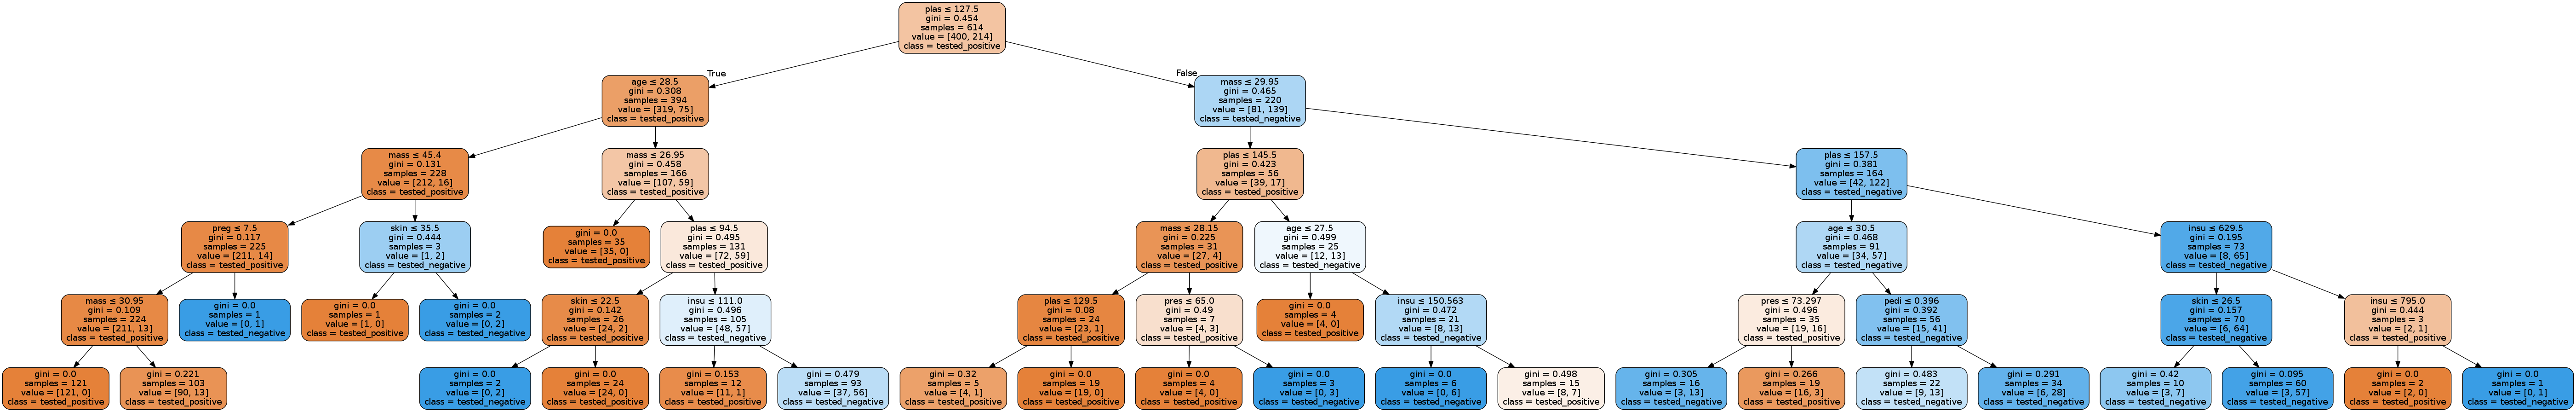

In [41]:
(train_attsCopy, test_attsCopy) = ImputerTrainTest('mean', train_atts[1], test_atts[1])

# Config the model
model = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_split = 2, random_state = seed)

# Train the classifier
classifier = model.fit(train_attsCopy, train_label[1])

# Print it
imprimeArbol(classifier, df[1], "500px")

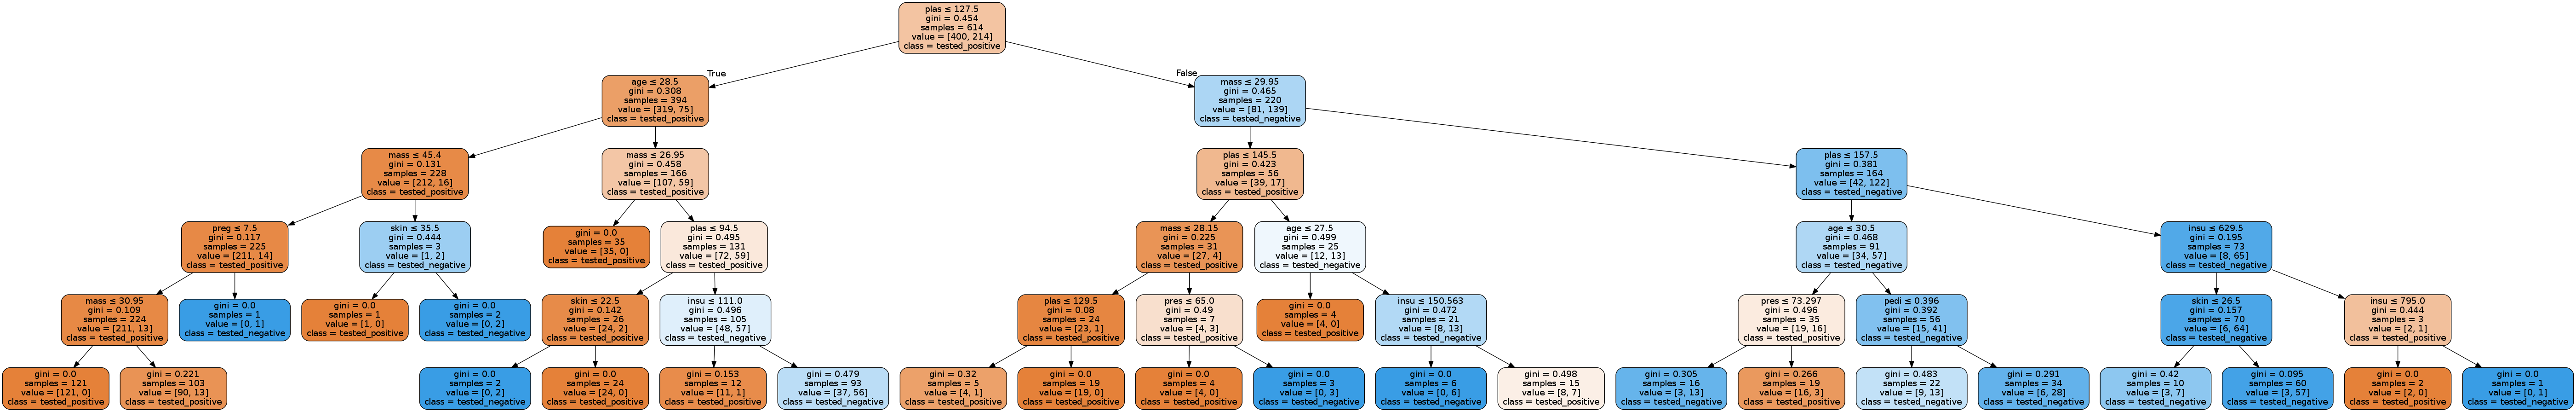

In [42]:
(train_attsCopy, test_attsCopy) = ImputerTrainTest('mean', train_atts[1], test_atts[1])

# Config the model
model = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 5, min_samples_split = 3, random_state = seed)

# Train the classifier
classifier = model.fit(train_attsCopy, train_label[1])

# Print it
imprimeArbol(classifier, df[1], "500px")

Analizando las estructuras del árbol óptimo y del subóptimo hemos concluido que son iguales, ya que todos los parámetros son iguales excepto el min_samples_split. Este parámetro no tiene relevancia puesto que en nigun nodo caen menos de 2 o 3 instancias de diferente clase.
También podemos comprobar que el último nivel, aunque se cumpla la condición de división, no se sigue diviendo puesto que superaria el límite máximo de profundidad.

### 5.2.2 Wisconsin

Con el ejecución del GridSearch sobre Wisconsin haciendo uso del Decision Tree hemos obtenido que la configuración óptima y la subóptima es:
- 0.957 (+/-0.024) for {'imputer_strategy': 'most_frequent', 'tree_criterion': 'entropy', 'tree_max_depth': None, 'tree_min_samples_split': 4, 'tree_random_state': 1234}

    
	Accuracy: 0.90714285714285714
    
	Recall: 0.77083333333333337
    
    Tiempo: 318 µs ± 44.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)
    
- 0.957 (+/-0.033) for {'imputer_strategy': 'most_frequent', 'tree_criterion': 'entropy', 'tree_max_depth': 5, 'tree_min_samples_split': 5, 'tree_random_state': 1234}

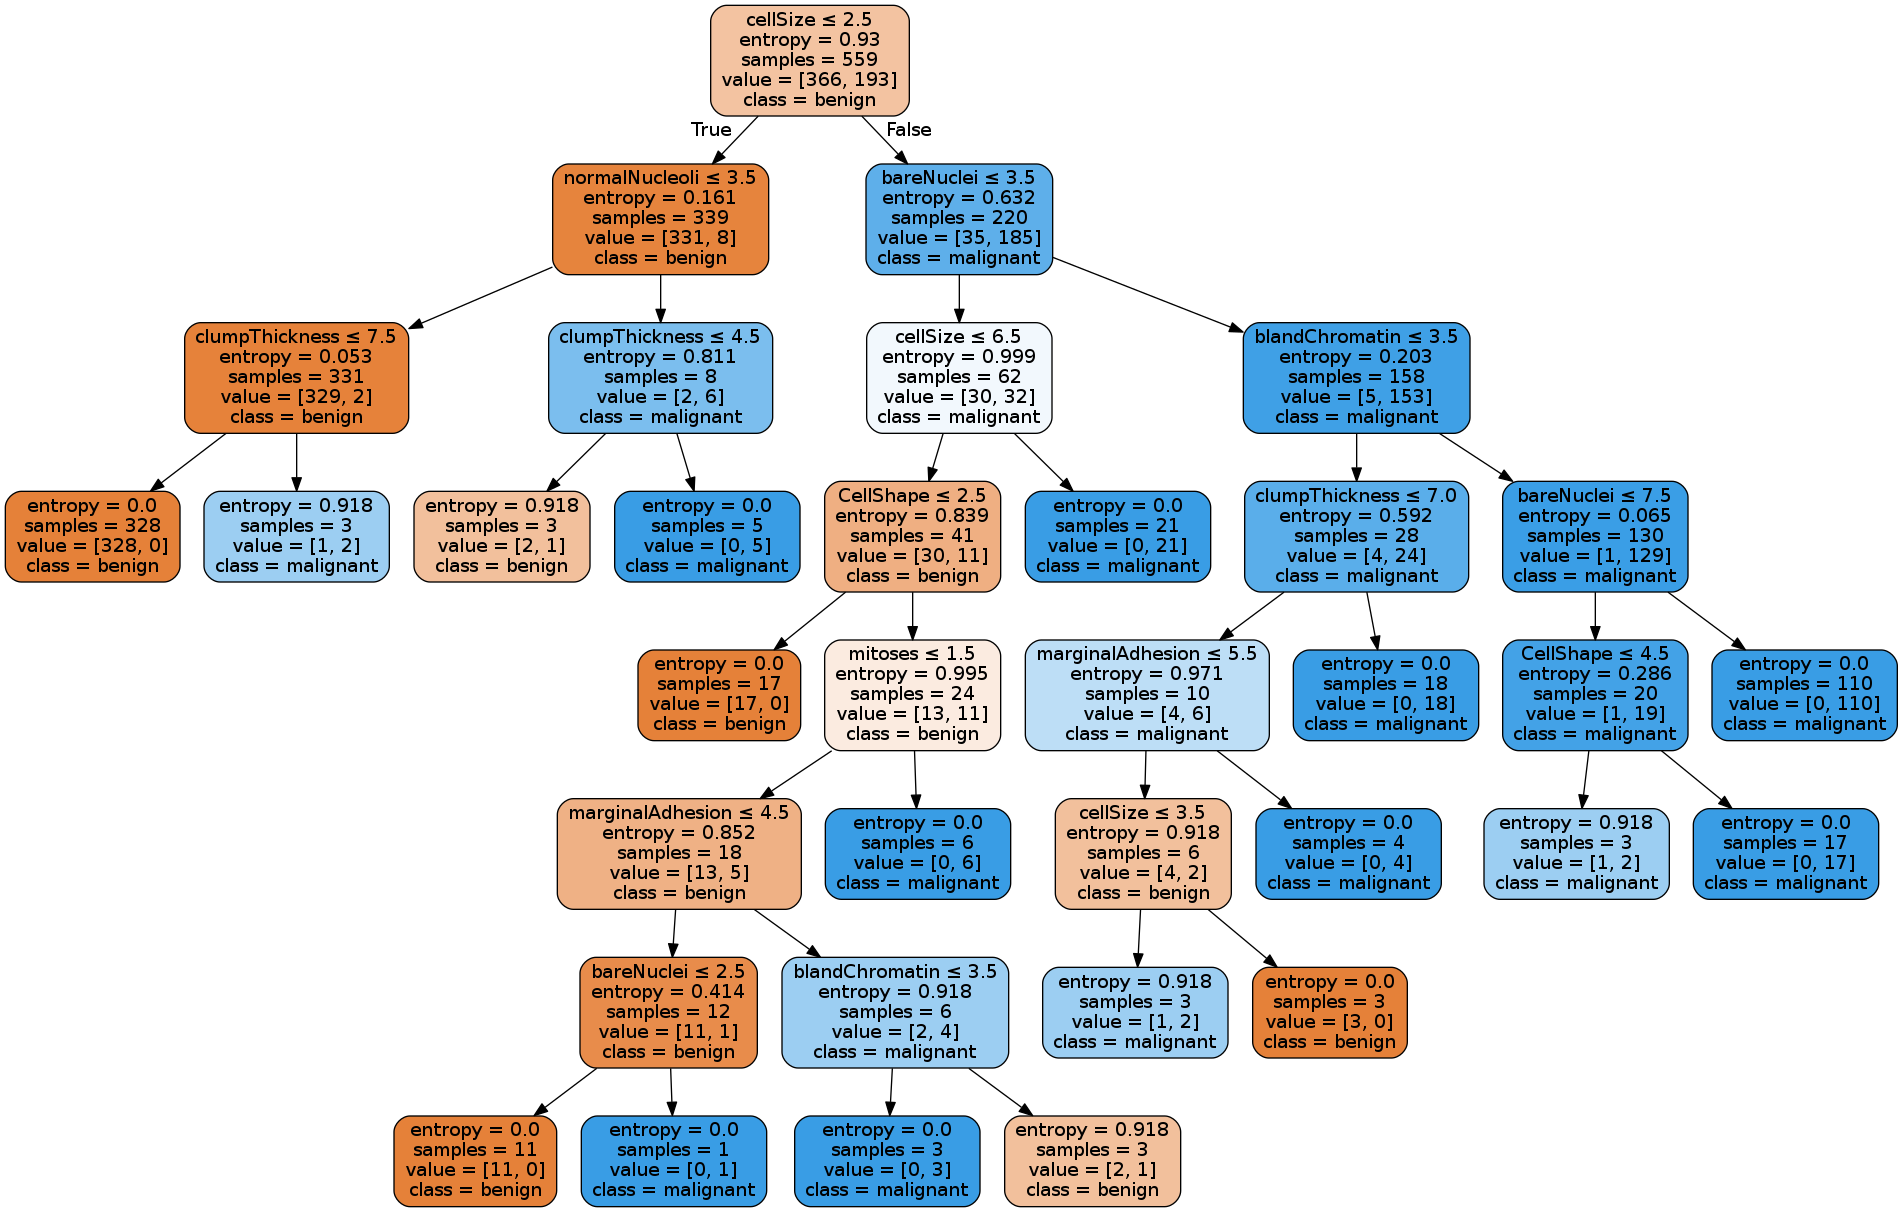

In [66]:
(train_attsCopy, test_attsCopy) = ImputerTrainTest('most_frequent', train_atts[2], test_atts[2])

# Config the model
model = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = None, min_samples_split = 4, random_state = seed)

# Train the classifier
classifier = model.fit(train_attsCopy, train_label[2])

# Print it
imprimeArbol(classifier, df[2], "500px")

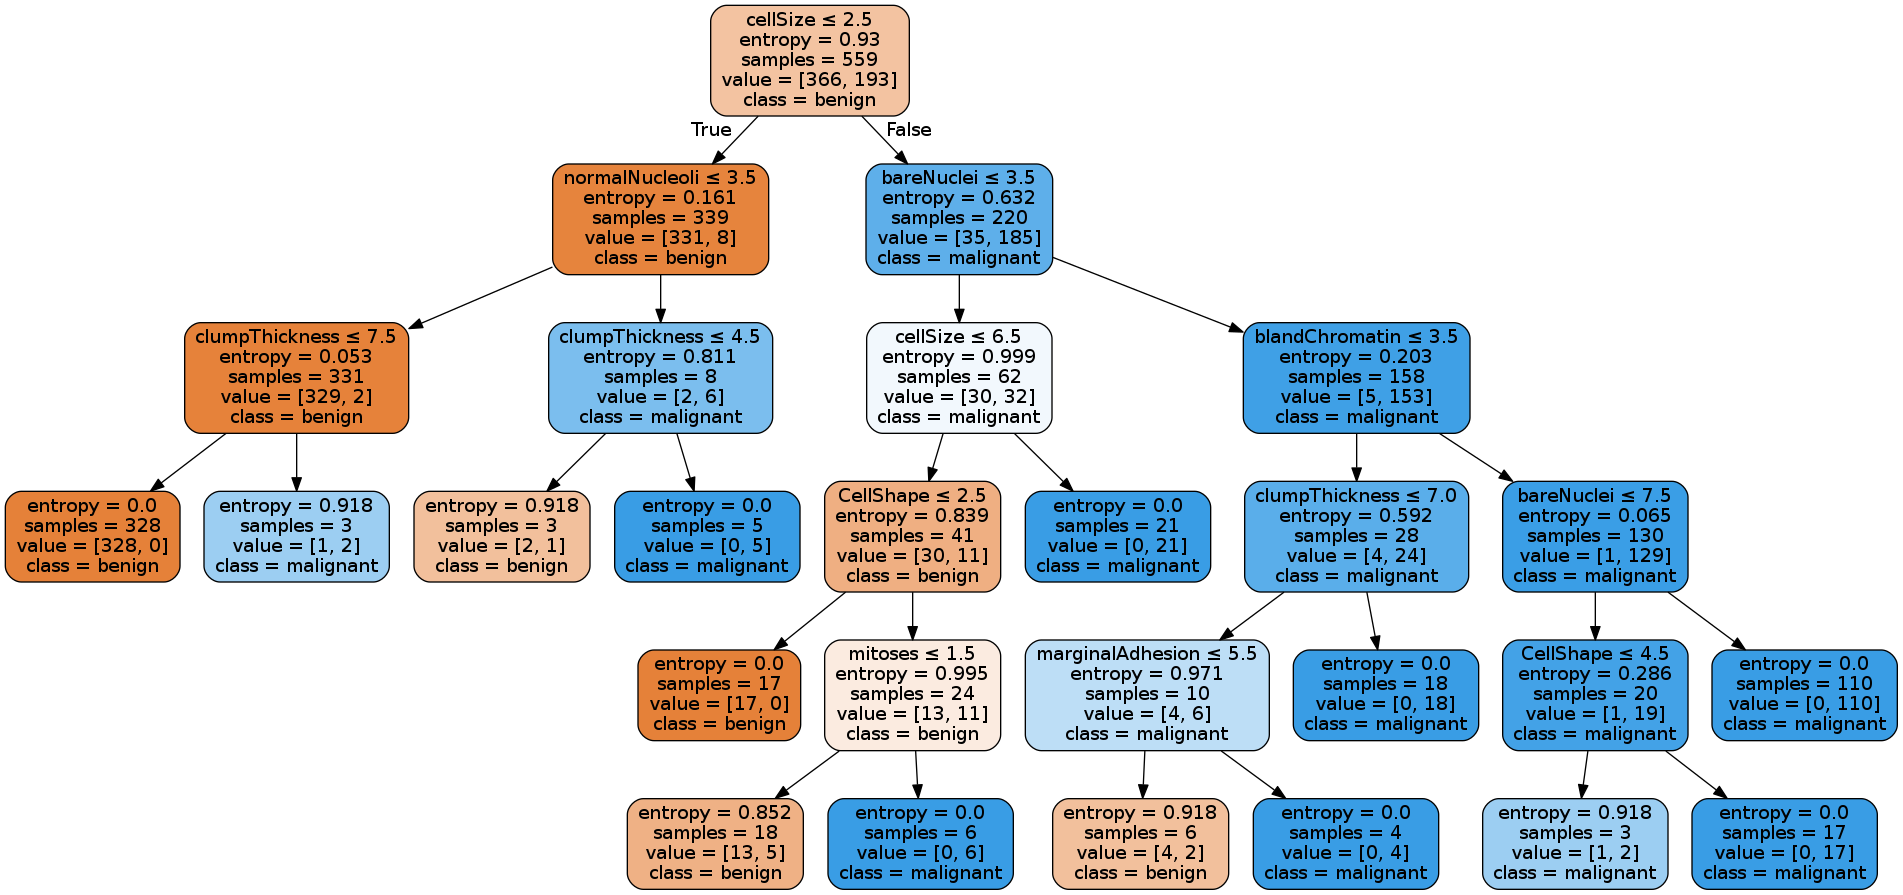

In [67]:
(train_attsCopy, test_attsCopy) = ImputerTrainTest('most_frequent', train_atts[2], test_atts[2])

# Config the model
model = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 5, min_samples_split = 5, random_state = seed)

# Train the classifier
classifier = model.fit(train_attsCopy, train_label[2])

# Print it
imprimeArbol(classifier, df[2], "500px")

La estructura del árbol es totalmente diferente, en el primero caso dado que el max_depth es None, el árbol se expanderá hasta que la condición de min_samples_split no lo permita o hasta que todas las hojas del árbol estén clasificadas por una misma clase.
En el segundo caso, los parámetros que cambian son min_samples_split y max_depth, en el caso de min_samples_split no afecta en la construcción del árbol puesto que nunca llegarán más de 5 casos de diferente clase para poder proceder a seguir dividiendo, excepto en el último nivel del árbol en el que max_depth no nos permite seguir avanzando.

Entre las dos configuraciones, elegimos sin duda la segunda, puesto que el árbol es más compacto (Navaja de Ockham) y más generico para la clasificación de nuevos casos, y además nos ofrece el mismo accuracy.

# 6. Algoritmo GridSearch - Manual

In [21]:
import itertools


estimator = Pipeline([("imputer", Imputer()),
                      ("tree", tree.DecisionTreeClassifier())])

# Definimos el param_grid con el que probaremos nuestra funcion.
# Es el mismo que el usado anteriormente [DecisionTree - Pima].

param_grid = { 'imputer__strategy': ['mean','most_frequent', 'median'],
               'tree__criterion' : ['entropy','gini'],
               'tree__max_depth' : [None] + [i for i in range(3,8)],
               'tree__min_samples_split' : np.arange(2,9),
               'tree__random_state' : [seed]}
                         



def gridSearchAJ(estimator, param_grid, scoring, cv, train_atts, train_label):
    # Diccionario de parametros que le pasaremos al clasificador
    param_gridElem = {}
    # Diccionario que almacena la configuracion con el mejor score
    elegido = {}
    maximoScore = 0
    # Recorrido del producto cartesiano de todos los valores obtenidos de param_grid
    for elemento in itertools.product(*list(param_grid.values())):
        # Recorrido de los elementos del param_grid
        for i in range(0, len(param_grid.keys())):
            # Almacenamos en el diccionario param_gridElem la siguiente configuracion. 
            param_gridElem[list(param_grid.keys())[i]] = elemento[i]
        # Pasamos los parametros al estimador mediante el diccionario con la configuracion a probar
        estimator.set_params(**param_gridElem)
        # Realizamos la validacion cruzada y obtenemos su Score.
        scoreCalculado = cross_val_score(estimator, train_atts, train_label, scoring = scoring, cv = cv).mean()
        # Si mejora el score con el que teniamos, almacenamos dicho valor y su configuracion
        if (scoreCalculado > maximoScore):
            maximoScore = scoreCalculado
            elegido = param_gridElem
    # Por ultimo, entrenamos el conjunto de datos de training con la mejor configuracion obtenida
    estimator.set_params(**elegido)
    estimator.fit(train_atts, train_label)
    # Devolvemos la mejor configuracion (como un diccionario), su score y el estimador entrenado
    return (elegido, maximoScore, estimator)
        
(elegido, maximoScore, fitted) = gridSearchAJ(estimator, param_grid, 'accuracy', 10, train_atts[1], train_label[1])

prediction = fitted.predict(test_atts[1])
%timeit -n 50 fitted.predict(test_atts[1])

411 µs ± 13 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [22]:
print (elegido)

{'imputer__strategy': 'median', 'tree__criterion': 'gini', 'tree__max_depth': 7, 'tree__min_samples_split': 8, 'tree__random_state': 1234}


In [23]:
print (maximoScore)

0.781755684823


In [24]:
metrics.confusion_matrix(test_label[1], prediction)

array([[73, 27],
       [17, 37]])

In [25]:
metrics.accuracy_score(test_label[1], prediction)

0.7142857142857143

In [26]:
metrics.recall_score(test_label[1], prediction, pos_label="tested_positive")

0.68518518518518523

Podemos observar que hemos obtenido el mismo Accuracy, con respecto a la configuración anterior obtenida con gridSearchCV, del conjunto de entrenamiento, por lo tanto, hemos obtenido una configuración distinta a la obtenida con el gridSearchCV de Scikit. Aunque dado que obtenemos el mismo Accuracy, podemos decir que hemos encontrado otro óptimo global, esto puede ser debido al orden en el que se hace el producto cartesiano con respecto al de Scikit. Es por ello que obtenemos un Recall, Acurracy y Matriz de confusión distintos tras la predicción, por ser distinta configuración.

# 7. Estudio de un kernel de kaggle

Echando un vistazo por la plataforma Kaggle, nos hemos decantado por el siguiente problema: "Mushroom Classification", en el que basicamente se da una base de datos con características de diferentes setas y nos lo clasifican sobre si son comestibles o no. Por lo tanto, los diferentes usuarios han realizado analisis de datos y algunos otros han provisto una clasificación.
Nos hemos decantado por la siguiente clasificación realizada por HaimFeldman de la siguiente dirección web: https://www.kaggle.com/haimfeld87/analysis-and-classification-of-mushrooms/data .
Estudio de la clasificación:
Primero se carga el dataset para posteriormente realizar un estudio de los datos (haciendo uso de gráficas y de tablas), con esto descubrió que un atributo no aportaba información (dado que el valor en todas las instancias era de 0), por lo tanto, procedió a eliminarla. También, comprobó que el dataset estaba balanceada. Por último, comprueba la correlación que tienen las variables predictoras entre ellas y descubre que la variable más importante para la clasificación ("gill-color") es la que presenta menor correlación.
Para crear un modelo de clasificación, hace uso de un "Decision Tree classfier" con el criterio por defecto (Gini). Después se da cuenta de la importancia de la variable "gill-color" y la estudia con mayor detenimiento (por ejemplo, mira que por cada valor de gill-color [es una variable discreta] que clase predomina). Al clasificar con el árbol de decisión se obtiene un Accuracy del 100% y un Recall del 100%, por lo tanto, está sobreajustado.
Como se ha obtenido un sobreajuste, su creador hace un estudio para ver a partir de que valor de profundidad se empieza a producir un sobreajuste.
Por último, el creador hace uso de un "Naive Bayes Gaussiano" y en este caso, al obtener la matriz de confusión no se presenta un sobreajute y se obtiene un r
Recall y un Accuracy del 91%. Es importante resaltar que hay al menos 37 casos que nos predice las setas venenosas como no venenosas, por lo tanto, se debería de intentar bajar este valor a practicamente 0, ya que peligra una vida humana. Aunque, deberías de resaltar que clasifica bastante bien, ya que es una dataset con al menos 800 instancias y solo 75 casos están mal clasificados; y no es un modelo sobreajustado.


PD: para ver mejor todo lo comentado, recomendamos acceder a la libreta disponible en la plataforma Kaggle (link proporcionado al comienzo de este texto).